In [2]:
# (No installation required)

In [3]:
# Import required libraries for sentiment analysis with open-source LLMs
import warnings
import os

warnings.filterwarnings('ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
from datetime import datetime
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
 )

# API setup for LLMs (Groq, dotenv)
from groq import Groq
from dotenv import load_dotenv

load_dotenv()

GROQ_API_KEY = os.getenv("GROQ_API_KEY")

if GROQ_API_KEY:
    groq_client = Groq(api_key=GROQ_API_KEY)

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

print("✓ Setup complete for open-source LLM sentiment analysis")

✓ Setup complete for open-source LLM sentiment analysis


## 1. Load Dataset

Load the FinancialPhraseBank dataset for sentiment analysis.

In [4]:
data_path = (
    "../../DatasetAnalysis_FinancialPhraseBank/FinancialPhraseBank-v1.0/Sentences_AllAgree.txt"
)

sentences = []
sentiments = []

with open(data_path, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        line = line.strip()
        if "@" in line:
            parts = line.rsplit("@", 1)
            if len(parts) == 2:
                sentences.append(parts[0])
                sentiments.append(parts[1])

df = pd.DataFrame({"sentence": sentences, "true_sentiment": sentiments})

print(f"Dataset loaded: {len(df)} sentences")
print(f"\nSentiment distribution:")
print(df["true_sentiment"].value_counts())

Dataset loaded: 2264 sentences

Sentiment distribution:
true_sentiment
neutral     1391
positive     570
negative     303
Name: count, dtype: int64


## 2. Few-Shot Examples

Curated examples (2 positive, 2 negative, 1 neutral) representing typical financial sentiment patterns.

In [5]:
# Curated few-shot examples
FEW_SHOT_EXAMPLES = [
    {
        "sentence": "Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007.",
        "sentiment": "positive",
        "rationale": "Operating profit increased significantly, indicating improved financial performance.",
    },
    {
        "sentence": "Net sales increased by 18.5% to EUR 167.8 million compared to the previous year.",
        "sentiment": "positive",
        "rationale": "Strong revenue growth of 18.5% signals business expansion and market success.",
    },
    {
        "sentence": "The company reported a net loss of EUR 2.5 million compared to a profit of EUR 1.2 million in the previous quarter.",
        "sentiment": "negative",
        "rationale": "Shift from profit to loss represents deteriorating financial health.",
    },
    {
        "sentence": "Sales decreased by 15% year-over-year due to weakening demand in key markets.",
        "sentiment": "negative",
        "rationale": "Significant sales decline indicates business challenges and market difficulties.",
    },
    {
        "sentence": "The company announced the appointment of a new chief financial officer effective next month.",
        "sentiment": "neutral",
        "rationale": "Executive appointment is routine corporate news without clear financial impact.",
    },
]

print("Few-Shot Examples:")
print("=" * 80)
for i, ex in enumerate(FEW_SHOT_EXAMPLES, 1):
    print(f"\nExample {i} [{ex['sentiment'].upper()}]:")
    print(f"Sentence: {ex['sentence']}")
    print(f"Rationale: {ex['rationale']}")

Few-Shot Examples:

Example 1 [POSITIVE]:
Sentence: Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007.
Rationale: Operating profit increased significantly, indicating improved financial performance.

Example 2 [POSITIVE]:
Sentence: Net sales increased by 18.5% to EUR 167.8 million compared to the previous year.
Rationale: Strong revenue growth of 18.5% signals business expansion and market success.

Example 3 [NEGATIVE]:
Sentence: The company reported a net loss of EUR 2.5 million compared to a profit of EUR 1.2 million in the previous quarter.
Rationale: Shift from profit to loss represents deteriorating financial health.

Example 4 [NEGATIVE]:
Sentence: Sales decreased by 15% year-over-year due to weakening demand in key markets.
Rationale: Significant sales decline indicates business challenges and market difficulties.

Example 5 [NEUTRAL]:
Sentence: The company announced the appointment of a new chief financial officer effective next month.
Ra

## 3. Few-Shot Prompt Design

Prompt template for open-source LLMs using few-shot examples.

In [6]:
def create_few_shot_prompt(sentence):
    """
    Creates a few-shot prompt with 5 labeled examples.
    """
    examples_text = ""
    for i, ex in enumerate(FEW_SHOT_EXAMPLES, 1):
        examples_text += f"""\nExample {i}:
Sentence: "{ex["sentence"]}"
Analysis:
{{
    "sentiment": "{ex["sentiment"]}",
    "confidence": 0.95,
    "rationale": "{ex["rationale"]}"
}}
"""

    prompt = f"""You are a financial sentiment analysis expert.

Classify the sentiment of financial statements as "positive", "negative", or "neutral" from an investor's perspective.

Guidelines:
- Positive: Good news for stock price (revenue increase, profit growth, expansion)
- Negative: Bad news for stock price (losses, declining sales, setbacks)
- Neutral: No clear impact or mixed signals

Here are 5 examples to learn from:
{examples_text}

Now classify this new statement:
Sentence: "{sentence}"

Provide your response in JSON format:
{{
    "sentiment": "positive/negative/neutral",
    "confidence": 0.0-1.0,
    "rationale": "Brief explanation"
}}
"""
    return prompt


# Test prompt
test_sentence = "The company's quarterly revenue exceeded analyst expectations by 12%."
print("=" * 80)
print("FEW-SHOT PROMPT EXAMPLE")
print("=" * 80)
print(create_few_shot_prompt(test_sentence)[:1000] + "...")

FEW-SHOT PROMPT EXAMPLE
You are a financial sentiment analysis expert.

Classify the sentiment of financial statements as "positive", "negative", or "neutral" from an investor's perspective.

Guidelines:
- Positive: Good news for stock price (revenue increase, profit growth, expansion)
- Negative: Bad news for stock price (losses, declining sales, setbacks)
- Neutral: No clear impact or mixed signals

Here are 5 examples to learn from:

Example 1:
Sentence: "Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007."
Analysis:
{
    "sentiment": "positive",
    "confidence": 0.95,
    "rationale": "Operating profit increased significantly, indicating improved financial performance."
}

Example 2:
Sentence: "Net sales increased by 18.5% to EUR 167.8 million compared to the previous year."
Analysis:
{
    "sentiment": "positive",
    "confidence": 0.95,
    "rationale": "Strong revenue growth of 18.5% signals business expansion and market success."
}

Examp

## 4. Model Inference Functions

Functions for calling open-source LLMs (Groq API) and parsing their responses.

In [7]:
#Call Llama or other OSS models via Groq API
def call_llama(prompt, model_name="llama-3.3-70b-versatile", temperature=0.0):
    """Call Llama or other OSS models via Groq API, with model selection"""
    max_retries = 3
    for attempt in range(max_retries):
        try:
            chat_completion = groq_client.chat.completions.create(
                messages=[{"role": "user", "content": prompt}],
                model=model_name,
                temperature=temperature,
                max_tokens=500,
            )
            return chat_completion.choices[0].message.content
        except Exception as e:
            if attempt < max_retries - 1:
                time.sleep(2**attempt)
                continue
            return None
    return None


def parse_response(response_text):
    """Parse JSON response from model"""
    try:
        if "```json" in response_text:
            json_str = response_text.split("```json")[1].split("```")[0].strip()
        elif "```" in response_text:
            json_str = response_text.split("```")[1].strip()
        else:
            json_str = response_text.strip()

        result = json.loads(json_str)
        return result
    except:
        response_lower = response_text.lower()
        if "positive" in response_lower and "negative" not in response_lower:
            return {
                "sentiment": "positive",
                "confidence": 0.5,
                "rationale": "Parsed from text",
            }
        elif "negative" in response_lower:
            return {
                "sentiment": "negative",
                "confidence": 0.5,
                "rationale": "Parsed from text",
            }
        elif "neutral" in response_lower:
            return {
                "sentiment": "neutral",
                "confidence": 0.5,
                "rationale": "Parsed from text",
            }
        return None


print("✓ Inference functions defined")


✓ Inference functions defined


## 5. Run Experiments

Run few-shot sentiment analysis using open-source LLMs:
- **E4:** GPT OSS 20B (Few-Shot)
- **E5:** GPT OSS 120B (Few-Shot)
- **E6:** Llama-3.3-70B (Few-Shot)

In [8]:
# For testing, use a sample of the dataset (remove .head(100) for full run)
test_df = df.head(100).copy()  # Remove .head(100) for full dataset

# E4: GPT OSS 20B (Few-Shot)
print("Running E4: GPT OSS 20B (Few-Shot)...")
e4_results = []

for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="E4 Progress"):
    prompt = create_few_shot_prompt(row["sentence"])
    response = call_llama(prompt, model_name="openai/gpt-oss-20b")

    if response:
        parsed = parse_response(response)
        if parsed:
            e4_results.append(
                {
                    "sentence": row["sentence"],
                    "true_sentiment": row["true_sentiment"],
                    "predicted_sentiment": parsed.get("sentiment", "unknown"),
                    "confidence": parsed.get("confidence", 0),
                    "rationale": parsed.get("rationale", ""),
                }
            )
        else:
            e4_results.append(
                {
                    "sentence": row["sentence"],
                    "true_sentiment": row["true_sentiment"],
                    "predicted_sentiment": "error",
                    "confidence": 0,
                    "rationale": "Parse error",
                }
            )

    time.sleep(0.5)  # Rate limiting

e4_df = pd.DataFrame(e4_results)
print(f"\n✓ E4 completed: {len(e4_df)} predictions")
display(e4_df.head())

Running E4: GPT OSS 20B (Few-Shot)...


E4 Progress: 100%|██████████| 100/100 [07:04<00:00,  4.24s/it]


✓ E4 completed: 100 predictions


,sentence,true_sentiment,predicted_sentiment,confidence,rationale
0,"According to Gran , the company has no plans t...",neutral,neutral,0.80,The statement merely reports that the company ...
1,"For the last quarter of 2010 , Componenta 's n...",positive,positive,0.97,Net sales doubled and the company eliminated i...
2,"In the third quarter of 2010 , net sales incre...",positive,positive,0.97,"Both net sales and operating profit rose, indi..."
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,positive,0.97,Operating profit increased from EUR 8.7 mn to ...
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,positive,0.95,Operating profit rose from EUR 18.6 mn to EUR ...


### E5: GPT OSS 120B (Few-Shot)

In [9]:
# E5: GPT OSS 120B (Few-Shot)
print("Running E5: GPT OSS 120B (Few-Shot)...")
e5_results = []

for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="E5 Progress"):
    prompt = create_few_shot_prompt(row["sentence"])
    response = call_llama(prompt, model_name="openai/gpt-oss-120b")

    if response:
        parsed = parse_response(response)
        if parsed:
            e5_results.append(
                {
                    "sentence": row["sentence"],
                    "true_sentiment": row["true_sentiment"],
                    "predicted_sentiment": parsed.get("sentiment", "unknown"),
                    "confidence": parsed.get("confidence", 0),
                    "rationale": parsed.get("rationale", ""),
                }
            )
        else:
            e5_results.append(
                {
                    "sentence": row["sentence"],
                    "true_sentiment": row["true_sentiment"],
                    "predicted_sentiment": "error",
                    "confidence": 0,
                    "rationale": "Parse error",
                }
            )

    time.sleep(0.5)

e5_df = pd.DataFrame(e5_results)
print(f"\n✓ E5 completed: {len(e5_df)} predictions")
display(e5_df.head())

Running E5: GPT OSS 120B (Few-Shot)...


E5 Progress: 100%|██████████| 100/100 [05:09<00:00,  3.10s/it]


✓ E5 completed: 100 predictions


,sentence,true_sentiment,predicted_sentiment,confidence,rationale
0,"According to Gran , the company has no plans t...",neutral,neutral,0.73,The statement indicates the company is expandi...
1,"For the last quarter of 2010 , Componenta 's n...",positive,positive,0.96,Doubling of net sales and turning a pre‑tax lo...
2,"In the third quarter of 2010 , net sales incre...",positive,positive,0.96,Both net sales and operating profit grew year‑...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,positive,0.96,Operating profit increased markedly from EUR 8...
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,positive,0.96,Operating profit increased from EUR 18.6 mn to...


### E6: Llama-3.3-70B (Few-Shot)

In [10]:
# E6: Llama-3.3-70B (Few-Shot)
print("Running E6: Llama-3.3-70B (Few-Shot)...")
e6_results = []

for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="E6 Progress"):
    prompt = create_few_shot_prompt(row["sentence"])
    response = call_llama(prompt, model_name="llama-3.3-70b-versatile")

    if response:
        parsed = parse_response(response)
        if parsed:
            e6_results.append(
                {
                    "sentence": row["sentence"],
                    "true_sentiment": row["true_sentiment"],
                    "predicted_sentiment": parsed.get("sentiment", "unknown"),
                    "confidence": parsed.get("confidence", 0),
                    "rationale": parsed.get("rationale", ""),
                }
            )
        else:
            e6_results.append(
                {
                    "sentence": row["sentence"],
                    "true_sentiment": row["true_sentiment"],
                    "predicted_sentiment": "error",
                    "confidence": 0,
                    "rationale": "Parse error",
                }
            )

    time.sleep(0.5)

e6_df = pd.DataFrame(e6_results)
print(f"\n✓ E6 completed: {len(e6_df)} predictions")
display(e6_df.head())

Running E6: Llama-3.3-70B (Few-Shot)...


E6 Progress: 100%|██████████| 100/100 [04:01<00:00,  2.42s/it]


✓ E6 completed: 100 predictions


,sentence,true_sentiment,predicted_sentiment,confidence,rationale
0,"According to Gran , the company has no plans t...",neutral,neutral,0.80,The statement provides information about the c...
1,"For the last quarter of 2010 , Componenta 's n...",positive,positive,0.95,Net sales doubled and the company moved from a...
2,"In the third quarter of 2010 , net sales incre...",positive,positive,0.98,Both net sales and operating profit showed sig...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,positive,0.95,Operating profit increased significantly from ...
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,positive,0.95,"Operating profit increased by EUR 2.5 mn, repr..."


## 6. Calculate Metrics

Compute accuracy, F1, precision, recall, and confusion matrices for each model.

In [11]:
def calculate_metrics(df, exp_name):
    """Calculate all evaluation metrics"""
    # Check if dataframe is empty or missing required columns
    if df.empty or "predicted_sentiment" not in df.columns:
        print(f"⚠️ Warning: {exp_name} has no valid predictions!")
        return (
            {
                "Experiment": exp_name,
                "Total Samples": 0,
                "Valid Predictions": 0,
                "Accuracy": 0,
                "Macro-F1": 0,
                "Weighted-F1": 0,
                "Macro-Precision": 0,
                "Macro-Recall": 0,
                "Positive_Precision": 0,
                "Positive_Recall": 0,
                "Positive_F1": 0,
                "Negative_Precision": 0,
                "Negative_Recall": 0,
                "Negative_F1": 0,
                "Neutral_Precision": 0,
                "Neutral_Recall": 0,
                "Neutral_F1": 0,
            },
            np.zeros((3, 3)),
            pd.DataFrame(),
        )

    # Filter out errors
    valid_df = df[
        df["predicted_sentiment"].isin(["positive", "negative", "neutral"])
    ].copy()

    # Check if we have valid predictions
    if valid_df.empty:
        print(f"⚠️ Warning: {exp_name} has no valid predictions after filtering!")
        return (
            {
                "Experiment": exp_name,
                "Total Samples": len(df),
                "Valid Predictions": 0,
                "Accuracy": 0,
                "Macro-F1": 0,
                "Weighted-F1": 0,
                "Macro-Precision": 0,
                "Macro-Recall": 0,
                "Positive_Precision": 0,
                "Positive_Recall": 0,
                "Positive_F1": 0,
                "Negative_Precision": 0,
                "Negative_Recall": 0,
                "Negative_F1": 0,
                "Neutral_Precision": 0,
                "Neutral_Recall": 0,
                "Neutral_F1": 0,
            },
            np.zeros((3, 3)),
            pd.DataFrame(),
        )

    y_true = valid_df["true_sentiment"]
    y_pred = valid_df["predicted_sentiment"]

    metrics = {
        "Experiment": exp_name,
        "Total Samples": len(df),
        "Valid Predictions": len(valid_df),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Macro-F1": f1_score(y_true, y_pred, average="macro"),
        "Weighted-F1": f1_score(y_true, y_pred, average="weighted"),
        "Macro-Precision": precision_score(y_true, y_pred, average="macro"),
        "Macro-Recall": recall_score(y_true, y_pred, average="macro"),
    }

    # Per-class metrics
    labels = ["positive", "negative", "neutral"]
    precision_per_class = precision_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )
    recall_per_class = recall_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )
    f1_per_class = f1_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )

    for i, label in enumerate(labels):
        metrics[f"{label.capitalize()}_Precision"] = precision_per_class[i]
        metrics[f"{label.capitalize()}_Recall"] = recall_per_class[i]
        metrics[f"{label.capitalize()}_F1"] = f1_per_class[i]

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    return metrics, cm, valid_df

# Calculate metrics for all experiments
e4_metrics, e4_cm, e4_valid = calculate_metrics(e4_df, "E4: GPT OSS 20B (Few-Shot)")
e5_metrics, e5_cm, e5_valid = calculate_metrics(e5_df, "E5: GPT OSS 120B (Few-Shot)")
e6_metrics, e6_cm, e6_valid = calculate_metrics(e6_df, "E6: Llama-3.3-70B (Few-Shot)")

# Create metrics comparison table
metrics_df = pd.DataFrame([e4_metrics, e5_metrics, e6_metrics])

print("\n" + "=" * 80)
print("FEW-SHOT PERFORMANCE COMPARISON")
print("=" * 80)
display(
    metrics_df[
        ["Experiment", "Accuracy", "Macro-F1", "Macro-Precision", "Macro-Recall"]
    ].round(4)
)


FEW-SHOT PERFORMANCE COMPARISON


/Users/sidharthrai/Documents/LJMU - MS AI ML/LJMU TrackThesis v3/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Experiment,Accuracy,Macro-F1,Macro-Precision,Macro-Recall
0,E4: GPT OSS 20B (Few-Shot),0.98,0.5982,0.6000,0.5965
1,E5: GPT OSS 120B (Few-Shot),1.00,1.0000,1.0000,1.0000
2,E6: Llama-3.3-70B (Few-Shot),0.99,0.9418,0.9948,0.9000


## 7. Visualize Results

Visualize performance metrics and confusion matrices for all open-source LLMs.

In [12]:
def calculate_metrics(df, exp_name):
    """Calculate all evaluation metrics"""
    # Check if dataframe is empty or missing required columns
    if df.empty or "predicted_sentiment" not in df.columns:
        print(f"⚠️ Warning: {exp_name} has no valid predictions!")
        return (
            {
                "Experiment": exp_name,
                "Total Samples": 0,
                "Valid Predictions": 0,
                "Accuracy": 0,
                "Macro-F1": 0,
                "Weighted-F1": 0,
                "Macro-Precision": 0,
                "Macro-Recall": 0,
                "Positive_Precision": 0,
                "Positive_Recall": 0,
                "Positive_F1": 0,
                "Negative_Precision": 0,
                "Negative_Recall": 0,
                "Negative_F1": 0,
                "Neutral_Precision": 0,
                "Neutral_Recall": 0,
                "Neutral_F1": 0,
            },
            np.zeros((3, 3)),
            pd.DataFrame(),
        )

    # Filter out errors
    valid_df = df[
        df["predicted_sentiment"].isin(["positive", "negative", "neutral"])
    ].copy()

    # Check if we have valid predictions
    if valid_df.empty:
        print(f"⚠️ Warning: {exp_name} has no valid predictions after filtering!")
        return (
            {
                "Experiment": exp_name,
                "Total Samples": len(df),
                "Valid Predictions": 0,
                "Accuracy": 0,
                "Macro-F1": 0,
                "Weighted-F1": 0,
                "Macro-Precision": 0,
                "Macro-Recall": 0,
                "Positive_Precision": 0,
                "Positive_Recall": 0,
                "Positive_F1": 0,
                "Negative_Precision": 0,
                "Negative_Recall": 0,
                "Negative_F1": 0,
                "Neutral_Precision": 0,
                "Neutral_Recall": 0,
                "Neutral_F1": 0,
            },
            np.zeros((3, 3)),
            pd.DataFrame(),
        )

    y_true = valid_df["true_sentiment"]
    y_pred = valid_df["predicted_sentiment"]

    metrics = {
        "Experiment": exp_name,
        "Total Samples": len(df),
        "Valid Predictions": len(valid_df),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Macro-F1": f1_score(y_true, y_pred, average="macro"),
        "Weighted-F1": f1_score(y_true, y_pred, average="weighted"),
        "Macro-Precision": precision_score(y_true, y_pred, average="macro"),
        "Macro-Recall": recall_score(y_true, y_pred, average="macro"),
    }

    # Per-class metrics
    labels = ["positive", "negative", "neutral"]
    precision_per_class = precision_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )
    recall_per_class = recall_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )
    f1_per_class = f1_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )

    for i, label in enumerate(labels):
        metrics[f"{label.capitalize()}_Precision"] = precision_per_class[i]
        metrics[f"{label.capitalize()}_Recall"] = recall_per_class[i]
        metrics[f"{label.capitalize()}_F1"] = f1_per_class[i]

    cm = confusion_matrix(y_true, y_pred, labels=labels)

    return metrics, cm, valid_df


# Calculate metrics for all experiments
e4_metrics, e4_cm, e4_valid = calculate_metrics(e4_df, "E4: GPT OSS 20B")
e5_metrics, e5_cm, e5_valid = calculate_metrics(e5_df, "E5: GPT OSS 120B")
e6_metrics, e6_cm, e6_valid = calculate_metrics(e6_df, "E6: Llama-3.3-70B")

# Create comparison table
metrics_df = pd.DataFrame([e4_metrics, e5_metrics, e6_metrics])

print("\n" + "=" * 80)
print("FEW-SHOT PERFORMANCE COMPARISON")
print("=" * 80)
display(
    metrics_df[
        ["Experiment", "Accuracy", "Macro-F1", "Macro-Precision", "Macro-Recall"]
    ].round(4)
)


FEW-SHOT PERFORMANCE COMPARISON


/Users/sidharthrai/Documents/LJMU - MS AI ML/LJMU TrackThesis v3/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Experiment,Accuracy,Macro-F1,Macro-Precision,Macro-Recall
0,E4: GPT OSS 20B,0.98,0.5982,0.6000,0.5965
1,E5: GPT OSS 120B,1.00,1.0000,1.0000,1.0000
2,E6: Llama-3.3-70B,0.99,0.9418,0.9948,0.9000


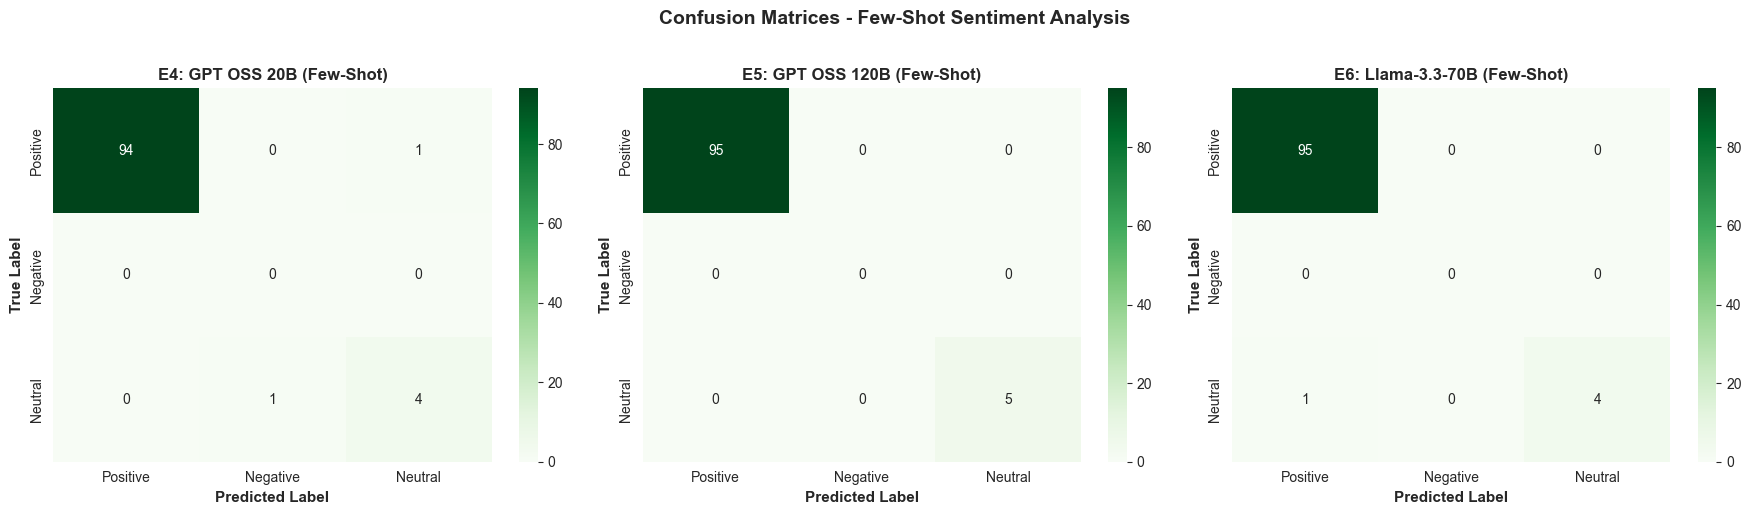

In [13]:
# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
labels = ["Positive", "Negative", "Neutral"]

for idx, (cm, title) in enumerate(
    [
        (e4_cm, "E4: GPT OSS 20B (Few-Shot)"),
        (e5_cm, "E5: GPT OSS 120B (Few-Shot)"),
        (e6_cm, "E6: Llama-3.3-70B (Few-Shot)"),
    ]
):
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Greens",
        xticklabels=labels,
        yticklabels=labels,
        ax=axes[idx],
    )
    axes[idx].set_title(title, fontsize=12, weight="bold")
    axes[idx].set_ylabel("True Label", fontsize=11, weight="bold")
    axes[idx].set_xlabel("Predicted Label", fontsize=11, weight="bold")

plt.suptitle(
    "Confusion Matrices - Few-Shot Sentiment Analysis",
    fontsize=14,
    weight="bold",
    y=1.02,
)
plt.tight_layout()
plt.savefig("few_shot_confusion_matrices.png", dpi=300, bbox_inches="tight")
plt.show()

## 8. Save Results

Save experiment results and metrics to CSV files.

In [14]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

e4_df.to_csv(f"e4_gpt_oss_20b_few_shot_{timestamp}.csv", index=False)
e5_df.to_csv(f"e5_gpt_oss_120b_few_shot_{timestamp}.csv", index=False)
e6_df.to_csv(f"e6_llama_few_shot_{timestamp}.csv", index=False)
metrics_df.to_csv(f"few_shot_metrics_summary_{timestamp}.csv", index=False)

print(f"\n✓ Results saved with timestamp: {timestamp}")


✓ Results saved with timestamp: 20260202_214607


## 9. Key Insights

### Few-Shot Learning Impact with Open-Source LLMs

1. **Learning from Examples:** Compare performance improvements vs zero-shot.
2. **Model Comparison:** Which open-source model benefits most from examples?
3. **Example Quality:** How do curated examples influence predictions?
4. **Confidence Calibration:** Are models more confident with examples?